Author - [Nitin Bhatnagar](https://medium.com/@captnitinbhatnagar/n-beats-the-unique-interpretable-deep-learning-model-for-time-series-forecasting-8dfdefaf0e34)

In [1]:
# Step 1: Install required libraries
#!pip install nbeats-pytorch pandas numpy matplotlib

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nbeats_pytorch.model import NBeatsNet
import torch
from torch.utils.data import DataLoader, Dataset

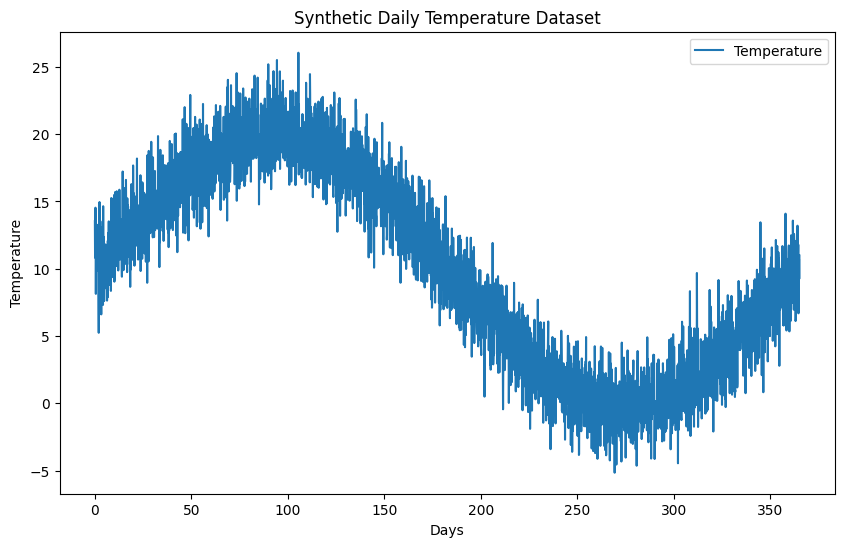

In [2]:
# Function to create a synthetic temperature dataset
def create_temperature_dataset(length, num_samples):
    np.random.seed(0)
    x = np.linspace(0, length, num_samples)
    seasonal = 10 + 10 * np.sin(2 * np.pi * x / 365)
    noise = np.random.normal(0, 2, num_samples)
    y = seasonal + noise
    return x, y

# Create dataset
x, y = create_temperature_dataset(365, 3650)

# Plot the dataset
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Temperature')
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.title('Synthetic Daily Temperature Dataset')
plt.legend()
plt.show()

In [3]:
# Step 2: Define a PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, backcast_length, forecast_length):
        self.data = data
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length

    def __len__(self):
        return len(self.data) - self.backcast_length - self.forecast_length

    def __getitem__(self, index):
        x = self.data[index : index + self.backcast_length]
        y = self.data[index + self.backcast_length : index + self.backcast_length + self.forecast_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Parameters
backcast_length = 30
forecast_length = 7

# Create dataset
dataset = TimeSeriesDataset(y, backcast_length, forecast_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Step 3: Define and Train the N-BEATS Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define N-BEATS model
model = NBeatsNet(
    device=device,
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
    forecast_length=forecast_length,
    backcast_length=backcast_length,
    hidden_layer_units=128
).to(device)

# Define loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
epochs = 50

for epoch in range(epochs):
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        backcast, forecast = model(x_batch)
        loss = criterion(forecast, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')


| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=False) at @136347488435360
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=False) at @136347488423696
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=False) at @136347488432768
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=30, forecast_length=7, share_thetas=False) at @136347488433008
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=30, forecast_length=7, share_thetas=False) at @136347488433776
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=30, forecast_length=7, share_thetas=False) at @136347488431088
Epoch 10/50, Loss: 4.452020645141602
Epoch 20/50, Loss: 3.346944808959961
Epoch 30/50, Loss: 2.4243173599243164
Epoc

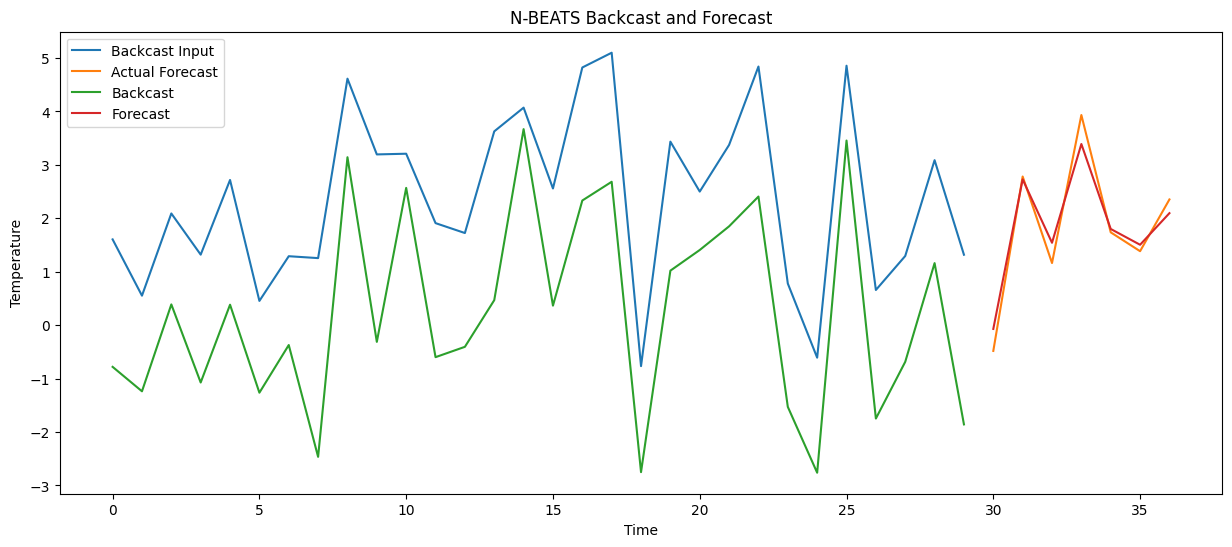

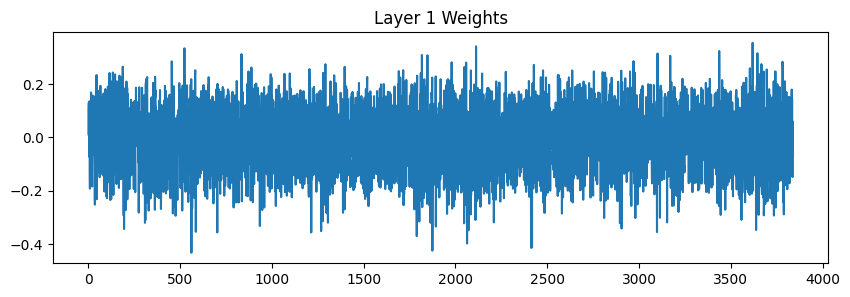

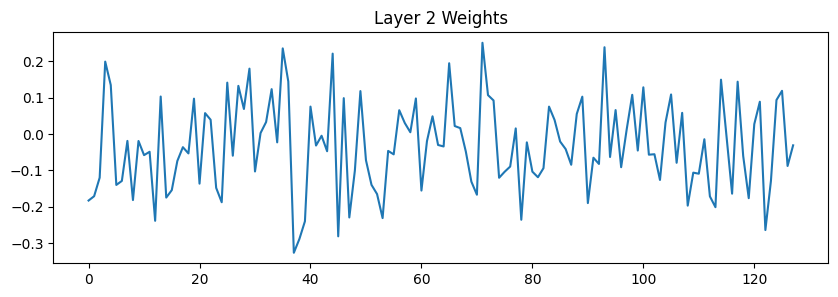

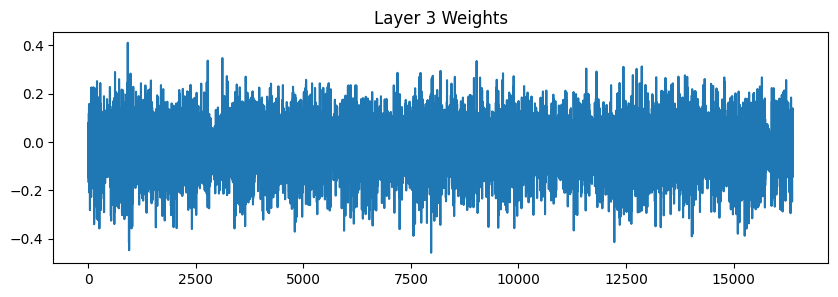

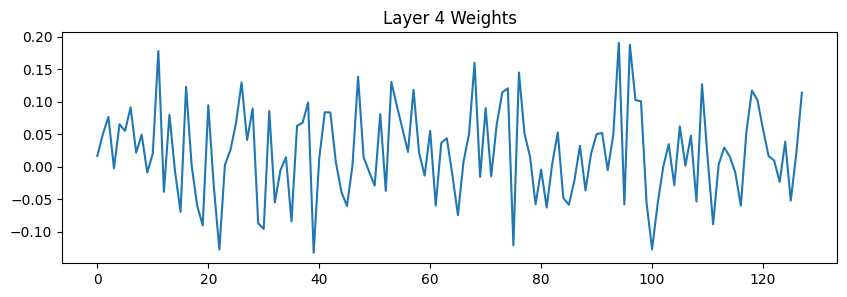

In [ ]:
# Step 4: Visualize Backcast, Forecast, and Model Weights
model.eval()
x_batch, y_batch = next(iter(dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

with torch.no_grad():
    backcast, forecast = model(x_batch)

# Convert to numpy for plotting
backcast = backcast.cpu().numpy()
forecast = forecast.cpu().numpy()
x_batch = x_batch.cpu().numpy()
y_batch = y_batch.cpu().numpy()

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(range(backcast_length), x_batch[0], label='Backcast Input')
plt.plot(range(backcast_length, backcast_length + forecast_length), y_batch[0], label='Actual Forecast')
plt.plot(range(backcast_length), backcast[0], label='Backcast')
plt.plot(range(backcast_length, backcast_length + forecast_length), forecast[0], label='Forecast')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('N-BEATS Backcast and Forecast')
plt.legend()
plt.show()

# Visualize model weights
weights = [param.cpu().data.numpy() for param in model.parameters()]

# Plot weights of the first few layers for illustration
for i, weight in enumerate(weights[:4]):
    plt.figure(figsize=(10, 3))
    plt.plot(weight.flatten())
    plt.title(f'Layer {i+1} Weights')
    plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE
mse = mean_squared_error(y_batch.flatten(), forecast.flatten())
mae = mean_absolute_error(y_batch.flatten(), forecast.flatten())

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 1.8896971940994263
Mean Absolute Error (MAE): 1.0033701658248901
